In [1]:
from math import sqrt
from numpy import concatenate
from matplotlib import pyplot
from pandas import read_csv
from pandas import DataFrame
from pandas import concat
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow import keras
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
import pandas as pd
import numpy as np

2023-04-16 01:53:37.963025: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-04-16 01:53:38.014670: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-04-16 01:53:38.015344: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-04-16 01:53:38.877612: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:
df_t = pd.read_csv('temperature.csv',index_col=0)
df_h = pd.read_csv('humidity.csv',index_col=0)
df_p = pd.read_csv('pressure.csv',index_col=0)
df_w = pd.read_csv('wind_speed.csv',index_col=0)
df_h.columns

Index(['Vancouver', 'Portland', 'San Francisco', 'Seattle', 'Los Angeles',
       'San Diego', 'Las Vegas', 'Phoenix', 'Albuquerque', 'Denver',
       'San Antonio', 'Dallas', 'Houston', 'Kansas City', 'Minneapolis',
       'Saint Louis', 'Chicago', 'Nashville', 'Indianapolis', 'Atlanta',
       'Detroit', 'Jacksonville', 'Charlotte', 'Miami', 'Pittsburgh',
       'Toronto', 'Philadelphia', 'New York', 'Montreal', 'Boston',
       'Beersheba', 'Tel Aviv District', 'Eilat', 'Haifa', 'Nahariyya',
       'Jerusalem'],
      dtype='object')

In [3]:
def normalize(data):
    data_mean = data.mean(axis=0)
    data_std = data.std(axis=0)
    return (data - data_mean) / data_std

In [4]:
city = 'Portland'
tempog = df_t[city]
temp = df_t[city].rename("temperature").to_frame(name='temperature')
humid = df_h[city].rename("humidity").to_frame(name='humidity')
press = df_p[city].rename("presure").to_frame(name='presure')
wind = df_w[city].rename("wind").to_frame(name='wind')


features = pd.concat([temp, press, humid, wind], axis=1)
# features.index = time
features = features.dropna()
features

featuresog = features
featuresog

,temperature,presure,humidity,wind
datetime,,,,
2012-10-01 13:00:00,282.080000,1024.0,81.0,0.0
2012-10-01 14:00:00,282.083252,1024.0,80.0,0.0
2012-10-01 15:00:00,282.091866,1024.0,80.0,0.0
2012-10-01 16:00:00,282.100481,1024.0,80.0,0.0
2012-10-01 17:00:00,282.109095,1024.0,79.0,0.0
...,...,...,...,...
2017-11-29 20:00:00,282.000000,1031.0,81.0,2.0
2017-11-29 21:00:00,282.890000,1030.0,71.0,1.0
2017-11-29 22:00:00,283.390000,1030.0,71.0,1.0


In [5]:
training_size = int ( 0.8 * features.shape[0])  

dataset=features.values
data_mean = dataset[:training_size].mean(axis=0)
data_std = dataset[:training_size].std(axis=0)
dataset = (dataset-data_mean)/data_std

dataset

array([[-0.41072376,  0.39673669,  0.32260978, -1.07594501],
       [-0.41027955,  0.39673669,  0.2700224 , -1.07594501],
       [-0.40910282,  0.39673669,  0.2700224 , -1.07594501],
       ...,
       [-0.23177994,  0.98959205, -0.20326401, -0.51718262],
       [-0.28232133,  0.89078283, -0.20326401,  0.04157978],
       [-0.3834041 ,  0.89078283,  0.05967288, -0.51718262]])

In [6]:
features = normalize(features.values)
features = pd.DataFrame(features)
features

,0,1,2,3
0,-0.395766,0.475706,0.331020,-1.122621
1,-0.395330,0.475706,0.278506,-1.122621
2,-0.394175,0.475706,0.278506,-1.122621
3,-0.393020,0.475706,0.278506,-1.122621
4,-0.391864,0.475706,0.225992,-1.122621
...,...,...,...,...
44796,-0.406494,1.178290,0.331020,-0.032614
44797,-0.287145,1.077921,-0.194119,-0.577618
44798,-0.220096,1.077921,-0.194119,-0.577618
44799,-0.269713,0.977552,-0.194119,-0.032614


In [7]:
past_history = 48
future_target = 24*3
STEP = 2

In [8]:
def multivariate_data(dataset, target, start_index, end_index, history_size,
                      target_size, step, single_step=False):
  data = []
  labels = []

  start_index = start_index + history_size
  if end_index is None:
    end_index = len(dataset) - target_size

  for i in range(start_index, end_index):
    indices = range(i-history_size, i, step)
    data.append(dataset[indices])

    if single_step:
      labels.append(target[i+target_size])
    else:
      labels.append(target[i:i+target_size])

  return np.array(data), np.array(labels)

In [9]:
x_train_multi, y_train_multi = multivariate_data(dataset, dataset[:, 1], 0,
                                                 training_size, past_history,
                                                 future_target, STEP)
x_val_multi, y_val_multi = multivariate_data(dataset, dataset[:, 1],
                                             training_size, None, past_history,
                                             future_target, STEP)

In [10]:
print ('Single window of past history : {}'.format(x_train_multi[0].shape))
print ('\n Target temperature to predict : {}'.format(y_train_multi[0].shape))

Single window of past history : (24, 4)

 Target temperature to predict : (72,)


In [11]:
BATCH_SIZE = 64
BUFFER_SIZE = 10000

train_data_multi = tf.data.Dataset.from_tensor_slices((x_train_multi, y_train_multi))
train_data_multi = train_data_multi.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE).repeat() # .repeat()

val_data_multi = tf.data.Dataset.from_tensor_slices((x_val_multi, y_val_multi))
val_data_multi = val_data_multi.batch(BATCH_SIZE).repeat() # .repeat()

2023-04-16 01:53:40.766379: W tensorflow/core/common_runtime/gpu/gpu_device.cc:1956] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


In [12]:
def multi_step_plot(history, true_future, prediction):
  plt.figure(figsize=(12, 6))
  num_in = create_time_steps(len(history))
  num_out = len(true_future)

  plt.plot(num_in, np.array(history[:, 1]), label='History')
  plt.plot(np.arange(num_out)/STEP, np.array(true_future), 'bo',
           label='True Future')
  if prediction.any():
    plt.plot(np.arange(num_out)/STEP, np.array(prediction), 'ro',
             label='Predicted Future')
  plt.legend(loc='upper left')
  plt.show()

In [13]:
multi_step_model = tf.keras.models.Sequential()
multi_step_model.add(tf.keras.layers.LSTM(32,
                                          return_sequences=True,
                                          input_shape=x_train_multi.shape[-2:]))
multi_step_model.add(tf.keras.layers.LSTM(16, activation='relu'))
multi_step_model.add(tf.keras.layers.Dense(future_target))

multi_step_model.compile(optimizer=keras.optimizers.Adam(learning_rate=0.001), loss="mse")

2023-04-16 01:53:41.122626: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-04-16 01:53:41.124222: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-04-16 01:53:41.125552: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

In [14]:
EVALUATION_INTERVAL = 200
EPOCHS = 5

multi_step_history = multi_step_model.fit(train_data_multi, epochs=EPOCHS,
                                          steps_per_epoch=EVALUATION_INTERVAL,
                                          validation_data=val_data_multi,
                                          validation_steps=50)

Epoch 1/5


2023-04-16 01:53:41.265953: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype double and shape [35792,72]
	 [[{{node Placeholder/_1}}]]
2023-04-16 01:53:41.266337: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype double and shape [35792,24,4]
	 [[{{node Placeholder/_0}}]]
2023-04-16 01:53:41.521491: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/s

200/200 [==============================] - ETA: 0s - loss: 0.5676

2023-04-16 01:53:46.572292: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype double and shape [8841,72]
	 [[{{node Placeholder/_1}}]]
2023-04-16 01:53:46.818328: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-04-16 01:53:46.819987: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor

200/200 [==============================] - 6s 15ms/step - loss: 0.5676 - val_loss: 1.4423
Epoch 2/5
200/200 [==============================] - 3s 13ms/step - loss: 0.4416 - val_loss: 1.1605
Epoch 3/5
200/200 [==============================] - 3s 13ms/step - loss: 0.4603 - val_loss: 1.1210
Epoch 4/5
200/200 [==============================] - 2s 12ms/step - loss: 0.4367 - val_loss: 1.2467
Epoch 5/5
200/200 [==============================] - 2s 12ms/step - loss: 0.3954 - val_loss: 1.0646


In [15]:
def create_time_steps(length):
  return list(range(-length, 0))

2023-04-16 01:53:57.297264: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype double and shape [8841,72]
	 [[{{node Placeholder/_1}}]]
2023-04-16 01:53:57.599006: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-04-16 01:53:57.600681: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor

2/2 [==============================] - 1s 5ms/step


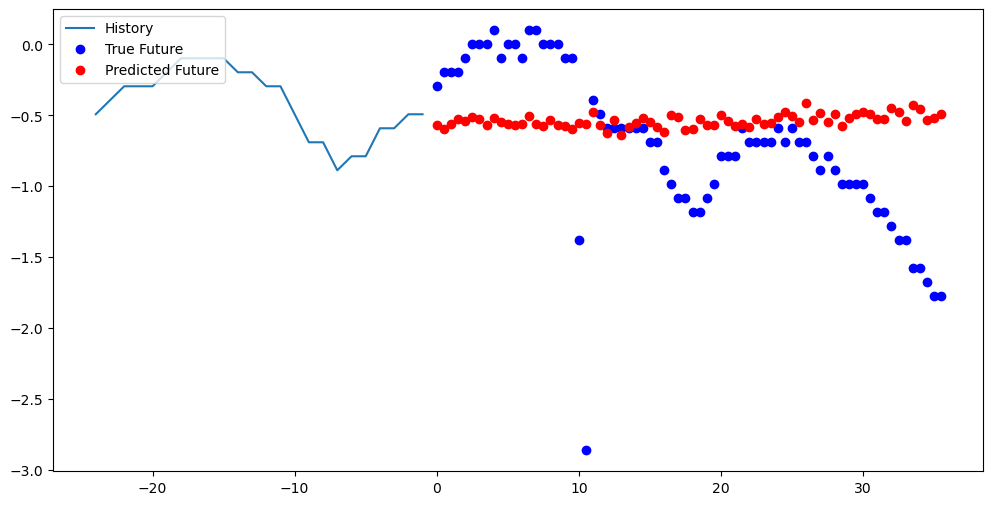

2/2 [==============================] - 0s 5ms/step


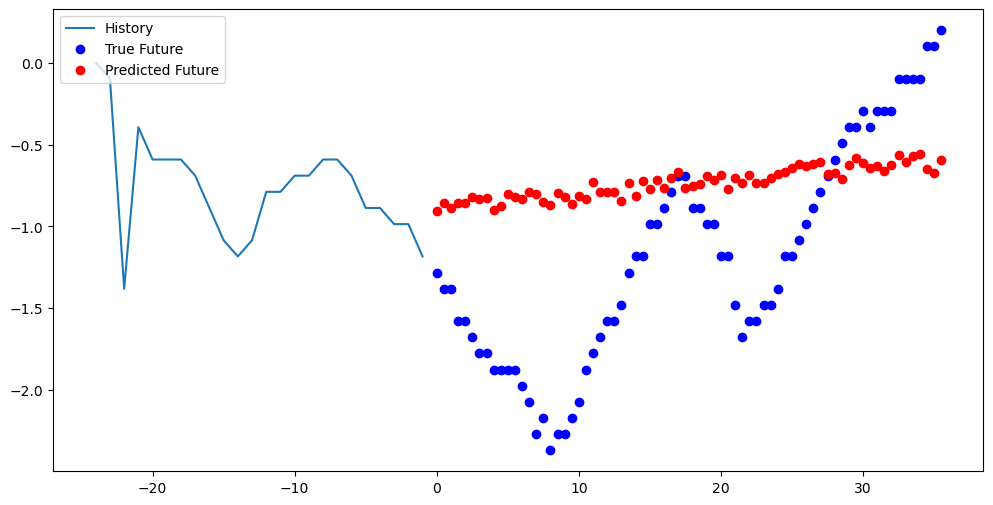

2/2 [==============================] - 0s 4ms/step


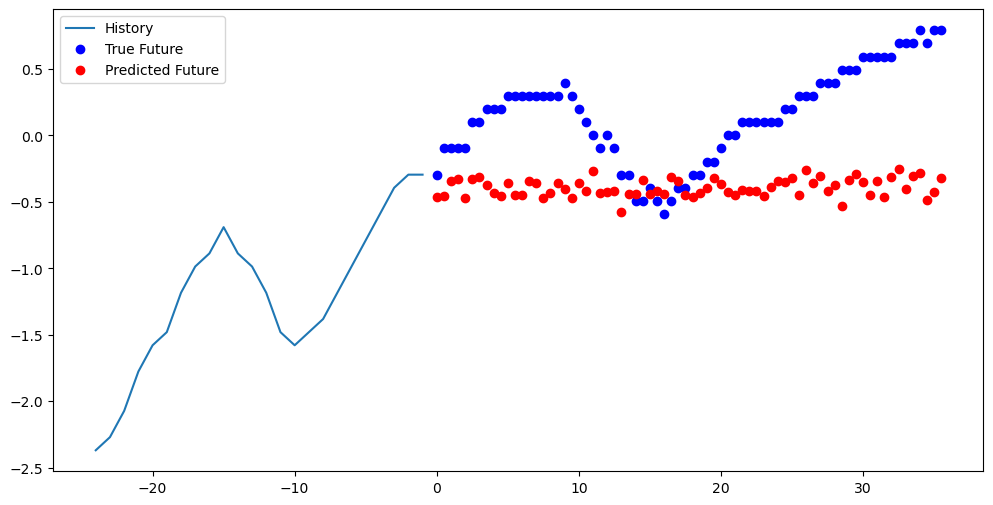

2/2 [==============================] - 0s 4ms/step


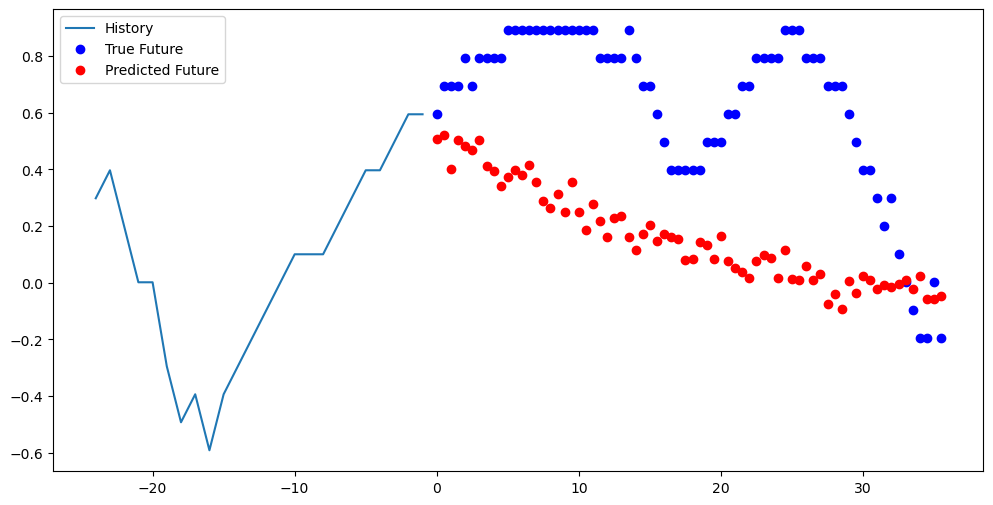

2/2 [==============================] - 0s 4ms/step


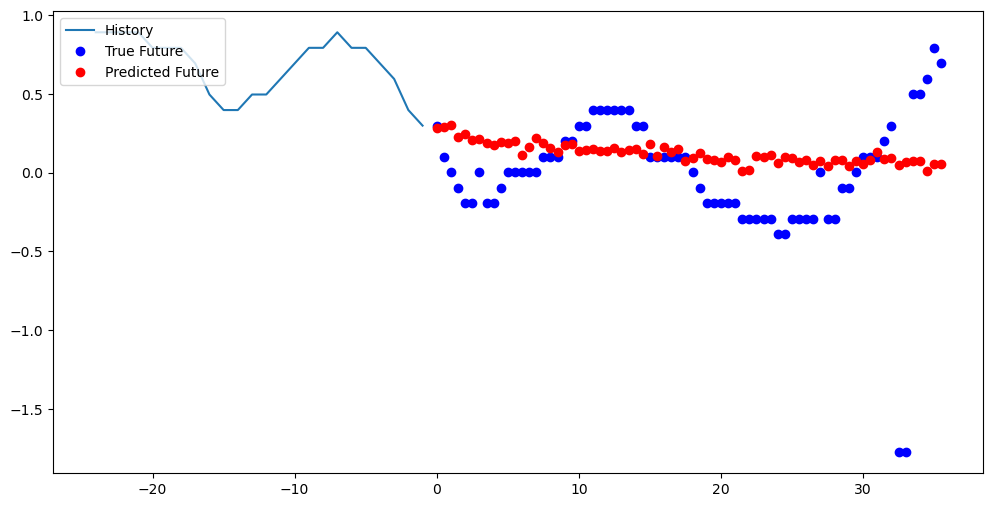

In [16]:
for x, y in val_data_multi.take(5):
  multi_step_plot(x[0], y[0], multi_step_model.predict(x)[0])

In [17]:
import math
trainPredict = multi_step_model.predict(x_train_multi)
testPredict = multi_step_model.predict(val_data_multi)
num_of_features=4
pred_col = featuresog.columns.get_loc("temperature")

# Get something which has as many features as dataset
trainPredict_extended = np.zeros((len(trainPredict),num_of_features))
# Put the predictions there
trainPredict_extended[:,pred_col] = trainPredict[:,0]
# Inverse transform it and select the 3rd column.
trainPredict = scaler.inverse_transform(trainPredict_extended) [:,pred_col]

# Get something which has as many features as dataset
testPredict_extended = np.zeros((len(testPredict),num_of_features))
# Put the predictions there
testPredict_extended[:,pred_col] = testPredict[:,0]
# Inverse transform it and select the pred_col column.
testPredict = scaler.inverse_transform(testPredict_extended)[:,pred_col] 

trainY_extended = np.zeros((len(trainY),num_of_features))
trainY_extended[:,pred_col]=trainY
trainY = scaler.inverse_transform(trainY_extended)[:,pred_col]

testY_extended = np.zeros((len(testY),num_of_features))
testY_extended[:,pred_col]=testY
testY = scaler.inverse_transform(testY_extended)[:,pred_col]

# calculate root mean squared error
trainScore_RMSE = math.sqrt(mean_squared_error(trainY, trainPredict))
testScore_RMSE = math.sqrt(mean_squared_error(testY, testPredict))

# calculate absolute mean error
trainScore_MAE = np.sum(np.absolute(trainY - trainPredict))/len(trainY)
testScore_MAE = np.sum(np.absolute(testY - testPredict))/len(testY)
# shift train predictions for plotting
trainPredictPlot = np.empty_like(dataset)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[look_back:len(trainPredict)+look_back, pred_col] = trainPredict

# shift test predictions for plotting
testPredictPlot = np.empty_like(dataset)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(trainPredict)+(look_back*2)+1:len(dataset)-1, pred_col] = testPredict

# contruct pandas dataframe for plotting
time_df = pd.DataFrame(featuresog.index)
time_df['Actual'] = scaler.inverse_transform(dataset)[:,pred_col]
df1 = pd.DataFrame(trainPredictPlot[:,pred_col],columns=['Train'])
df2 = pd.DataFrame(testPredictPlot[:,pred_col],columns=['Test'])
time_df2 = pd.concat([time_df, df1, df2], axis=1, sort=False)

# print(time_df2)

time_df2.set_index('datetime',inplace=True)

# plot the output
fig, ax = plt.subplots(figsize=(15,7))
time_df2.plot(ax=ax,rot=90,alpha=0.7)
plt.xlabel('Timestamp')
plt.ylabel('Temperature Value')
plt.title('Temperature Prediction')
plt.savefig(expr_name + '.png',bbox_inches = "tight")



2023-04-16 01:53:59.346202: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-04-16 01:53:59.348004: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-04-16 01:53:59.349358: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

1119/1119 [==============================] - 4s 3ms/step


ValueError: When providing an infinite dataset, you must specify the number of steps to run (if you did not intend to create an infinite dataset, make sure to not call `repeat()` on the dataset).